<a href="https://colab.research.google.com/github/kuotuantuan/Fraud-Detection/blob/main/Random%20Forest/ethereum-fraud-detection-eda-model-selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This dataset contains rows of known fraud and valid transactions made over Ethereum.



### Task: EDA & Prediction of Fraud/Valid Transaction

Here is a description of the rows of the dataset:
* Index: the index number of a row
* Address: the address of the ethereum account
* FLAG: whether the transaction is fraud or not
* Avg min between sent tnx: Average time between sent transactions for account in minutes
* Avgminbetweenreceivedtnx: Average time between received transactions for account in minutes
* TimeDiffbetweenfirstand_last(Mins): Time difference between the first and last transaction
* Sent_tnx: Total number of sent normal transactions
* Received_tnx: Total number of received normal transactions
* NumberofCreated_Contracts: Total Number of created contract transactions
* UniqueReceivedFrom_Addresses: Total Unique addresses from which account received transactions
* UniqueSentTo_Addresses20: Total Unique addresses from which account sent transactions
* MinValueReceived: Minimum value in Ether ever received
* MaxValueReceived: Maximum value in Ether ever received
* AvgValueReceived5Average value in Ether ever received
* MinValSent: Minimum value of Ether ever sent
* MaxValSent: Maximum value of Ether ever sent
* AvgValSent: Average value of Ether ever sent
* MinValueSentToContract: Minimum value of Ether sent to a contract
* MaxValueSentToContract: Maximum value of Ether sent to a contract
* AvgValueSentToContract: Average value of Ether sent to contracts
* TotalTransactions(IncludingTnxtoCreate_Contract): Total number of transactions
* TotalEtherSent:Total Ether sent for account address
* TotalEtherReceived: Total Ether received for account address
* TotalEtherSent_Contracts: Total Ether sent to Contract addresses
* TotalEtherBalance: Total Ether Balance following enacted transactions
* TotalERC20Tnxs: Total number of ERC20 token transfer transactions
* ERC20TotalEther_Received: Total ERC20 token received transactions in Ether
* ERC20TotalEther_Sent: Total ERC20token sent transactions in Ether
* ERC20TotalEtherSentContract: Total ERC20 token transfer to other contracts in Ether
* ERC20UniqSent_Addr: Number of ERC20 token transactions sent to Unique account addresses
* ERC20UniqRec_Addr: Number of ERC20 token transactions received from Unique addresses
* ERC20UniqRecContractAddr: Number of ERC20token transactions received from Unique contract addresses
* ERC20AvgTimeBetweenSent_Tnx: Average time between ERC20 token sent transactions in minutes
* ERC20AvgTimeBetweenRec_Tnx: Average time between ERC20 token received transactions in minutes
* ERC20AvgTimeBetweenContract_Tnx: Average time ERC20 token between sent token transactions
* ERC20MinVal_Rec: Minimum value in Ether received from ERC20 token transactions for account
* ERC20MaxVal_Rec: Maximum value in Ether received from ERC20 token transactions for account
* ERC20AvgVal_Rec: Average value in Ether received from ERC20 token transactions for account
* ERC20MinVal_Sent: Minimum value in Ether sent from ERC20 token transactions for account
* ERC20MaxVal_Sent: Maximum value in Ether sent from ERC20 token transactions for account
* ERC20AvgVal_Sent: Average value in Ether sent from ERC20 token transactions for account
* ERC20UniqSentTokenName: Number of Unique ERC20 tokens transferred
* ERC20UniqRecTokenName: Number of Unique ERC20 tokens received
* ERC20MostSentTokenType: Most sent token for account via ERC20 transaction
* ERC20MostRecTokenType: Most received token for account via ERC20 transactions

## Code start

### Data Input and Description

In [ ]:
# pip install klib

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import klib

from sklearn.model_selection import StratifiedKFold, cross_validate, learning_curve, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, plot_confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import lightgbm as lgb

import os
import sys

In [5]:
df = pd.read_csv('/content/transaction_dataset.csv', index_col=[0])
df.drop(columns='Index', inplace=True)
df.drop_duplicates(inplace=True)

In [6]:
# sampling some observations
print(df.shape)
# df.sample(3)

(9823, 49)


In [7]:
# column names
# display(df.columns)

# describtion of numeratic columns
# display(df.describe())

# Non-Null Count and type of columns
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9823 entries, 0 to 9840
Data columns (total 49 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Address                                               9823 non-null   object 
 1   FLAG                                                  9823 non-null   int64  
 2   Avg min between sent tnx                              9823 non-null   float64
 3   Avg min between received tnx                          9823 non-null   float64
 4   Time Diff between first and last (Mins)               9823 non-null   float64
 5   Sent tnx                                              9823 non-null   int64  
 6   Received Tnx                                          9823 non-null   int64  
 7   Number of Created Contracts                           9823 non-null   int64  
 8   Unique Received From Addresses                        9823

None

### Variables with 0 variance

In [8]:
zero_feature_list = df.columns[(df.nunique() == 1)].tolist()
zero_feature_list

[' ERC20 avg time between sent tnx',
 ' ERC20 avg time between rec tnx',
 ' ERC20 avg time between rec 2 tnx',
 ' ERC20 avg time between contract tnx',
 ' ERC20 min val sent contract',
 ' ERC20 max val sent contract',
 ' ERC20 avg val sent contract']

### Categorical columns

#### Check Address

In [9]:
# non-unique adresses
_, uniq_idx, counts = np.unique(df['Address'].to_numpy(), return_index=True, return_counts=True)
non_unique_addresses_idx = uniq_idx[counts > 1]
print("non-unique adresses count: {}".format(len(non_unique_addresses_idx), end='\n\n'))
# The flags of non-uniqe adresses
non_unique_addresses_flags = df.iloc[non_unique_addresses_idx]['FLAG']
print("flags of non-unique adresses: ", end='')
print(*non_unique_addresses_flags)

non-unique adresses count: 7
flags of non-unique adresses: 0 0 0 0 0 0 0


In [10]:
df['Non_unique_Address'] = 0
df.loc[non_unique_addresses_idx, 'Non_unique_Address'] = 1

In [11]:
feature_list = list(set(df.columns) - set(['Address', 'FLAG']) - set(zero_feature_list))
num_feature_list = list(set(feature_list) - set(df.dtypes[df.dtypes == 'object'].index) - set(zero_feature_list))
cat_feature_list = list(set(feature_list) - set(num_feature_list))

assert len(feature_list) == len(num_feature_list) + len(cat_feature_list)

In [12]:
cat_feature_list

[' ERC20_most_rec_token_type', ' ERC20 most sent token type']

### Numerical columns

In [13]:
# are classes balanced?
print('class : count : percent')
print('0     : {}  : {:.2%}'.format(sum(df['FLAG']==0), sum(df['FLAG']==0)/len(df['FLAG']) ))
print('1     : {}  : {:.2%}'.format(sum(df['FLAG']==1), sum(df['FLAG']==1)/len(df['FLAG']) ))

class : count : percent
0     : 7644  : 77.82%
1     : 2179  : 22.18%


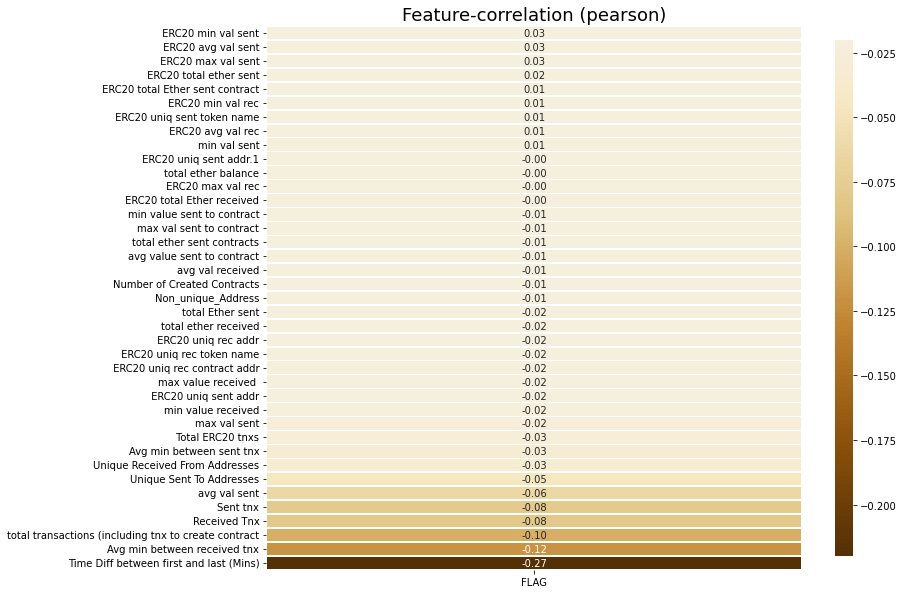

In [14]:
# find the correlation with all other numeric variables in the raw data set
klib.corr_plot(df[num_feature_list+['FLAG']], target='FLAG')

Dataset is unbalanced, we must remember about this when choosing our model metric.

### Missing Values

In [15]:
# missing values
missing_values = df.isna()
missing_percent = missing_values.sum() / df.shape[0] * 100
missing_df = pd.DataFrame([missing_values.sum(), missing_percent], ['count', 'percent'])
display(missing_df.sort_values(by='percent', axis=1, ascending=False))
missing_df.sort_values(by='percent', axis=1, ascending=False).to_csv('missing.csv')

,ERC20_most_rec_token_type,ERC20 most sent token type,ERC20 total Ether received,ERC20 min val rec,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 avg val rec,ERC20 max val rec,ERC20 total ether sent,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,Total ERC20 tnxs,Address,FLAG,total ether balance,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,Non_unique_Address
count,851.000000,841.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent,8.663341,8.561539,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,8.439377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Looks like missing values are highly connected to fraud cases

In [16]:
non_fraud_rows, fraud_rows = np.where( [df.loc[:,'FLAG']==1] )
print(df.iloc[fraud_rows,:].isna().sum()[-20:])

 ERC20 uniq sent addr.1                 829
 ERC20 uniq rec contract addr           829
 ERC20 avg time between sent tnx        829
 ERC20 avg time between rec tnx         829
 ERC20 avg time between rec 2 tnx       829
 ERC20 avg time between contract tnx    829
 ERC20 min val rec                      829
 ERC20 max val rec                      829
 ERC20 avg val rec                      829
 ERC20 min val sent                     829
 ERC20 max val sent                     829
 ERC20 avg val sent                     829
 ERC20 min val sent contract            829
 ERC20 max val sent contract            829
 ERC20 avg val sent contract            829
 ERC20 uniq sent token name             829
 ERC20 uniq rec token name              829
 ERC20 most sent token type             829
 ERC20_most_rec_token_type              829
Non_unique_Address                        0
dtype: int64


As we expected every missing value is in fraud rows. That means that almost 40% of fraud rows have missing values.

In [17]:
missing_columns = df.columns[df.isna().sum() > 0]

In [18]:
missing_columns

Index([' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx',
       ' ERC20 avg time between rec 2 tnx',
       ' ERC20 avg time between contract tnx', ' ERC20 min val rec',
       ' ERC20 max val rec', ' ERC20 avg val rec', ' ERC20 min val sent',
       ' ERC20 max val sent', ' ERC20 avg val sent',
       ' ERC20 min val sent contract', ' ERC20 max val sent contract',
       ' ERC20 avg val sent contract', ' ERC20 uniq sent token name',
       ' ERC20 uniq rec token name', ' ERC20 most sent token type',
       ' ERC20_most_rec_token_type'],
      dtype='object')

In [20]:
df.shape[0]-df.dropna().shape[0]

860

In [21]:
df_without_missing_row = df.dropna()
df_without_missing_col = df.drop(columns=missing_columns)

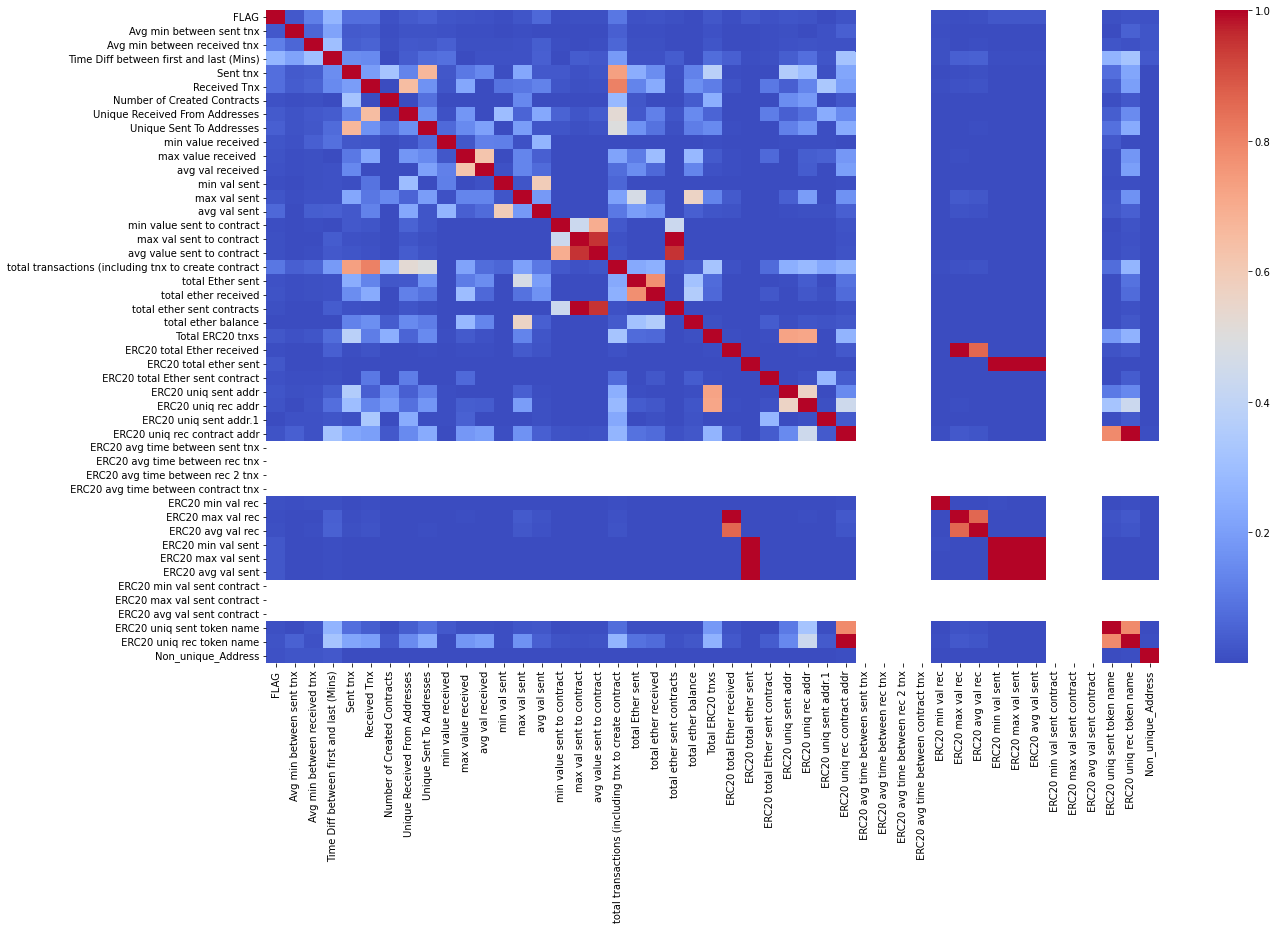

In [22]:
# correlation
corr = df.corr()
plt.figure(figsize=(20,12))
sns.heatmap(np.abs(corr), cmap='coolwarm')
plt.show()

## Data preprocessing

In [23]:
def data_preporcess(df, test_size, random_state, shuffle):
    y = df.loc[:, 'FLAG']
    x = df.drop(columns='FLAG')
    print('Total shape: ', x.shape, y.shape)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    print('Train shape: ', x_train.shape, y_train.shape)
    print('Test shape: ', x_test.shape, y_test.shape)

    return x, y, x_train, y_train, x_test, y_test

In [24]:
def normalize_dat(df):
    # Normalize data
    norm = PowerTransformer()
    norm_df = norm.fit_transform(df)
    return norm_df, norm

### Imbalance Data
Oversampling using SMOTE

In [25]:
def smote_balance(x_train, y_train):
    oversample = SMOTE()
    print(f'Shape of the training before SMOTE: {x_train.shape, y_train.shape}')

    x_tr_resample, y_tr_resample = oversample.fit_resample(x_train, y_train)
    print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

    # Target distribution before SMOTE
    non_fraud = 0
    fraud = 0

    for i in y_train:
        if i == 0:
            non_fraud +=1
        else:
            fraud +=1

    # Target distribution after SMOTE
    no = 0
    yes = 1

    for j in y_tr_resample:
        if j == 0:
            no +=1
        else:
            yes +=1


    print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
    print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

    return x_tr_resample, y_tr_resample

## Model selection

In [26]:
def evaluate_models(X, y, models, cv):
    f1_scores = dict()
    acc_scores = dict()
    
    for i, model in enumerate(models):
        clf_pipeline = make_pipeline(preprocessing_pipeline, model)
        results = cross_validate(clf_pipeline, X, y, cv=cv, scoring=['f1', 'accuracy'], n_jobs=-1)
        avg_f1 = np.mean(results['test_f1'])
        avg_acc = np.mean(results['test_accuracy'])
        
        model_name = model.__class__.__name__
        f1_scores[model_name] = avg_f1
        acc_scores[model_name] = avg_acc
        print('{}-of-{}: {} f1={}, acc={}'.format(i+1, len(models), model_name, avg_f1, avg_acc))
    return f1_scores, acc_scores

In [27]:
def visualize_scores(f1_scores, acc_scores):
    x = np.arange(len(f1_scores))
    width = 0.45
    
    f1_values = list(f1_scores.values())
    acc_values = list(acc_scores.values())
    
    plt.figure(figsize=(15, 8)).tight_layout()
    plt.bar(x - width / 2, f1_values, width, label='f1 score')
    plt.bar(x + width / 2, acc_values, width, label='accuracy')
    
    for index, value in enumerate(x - width / 2):
        plt.text(value, f1_values[index], '{:.3}'.format(f1_values[index]),
                 verticalalignment='bottom', horizontalalignment='center', fontsize=10)

    for index, value in enumerate(x + width / 2):
        plt.text(value, acc_values[index], '{:.3}'.format(acc_values[index]),
                 verticalalignment='bottom', horizontalalignment='center', fontsize=10)    
    
    classifiers_names = f1_scores.keys()
    plt.xticks(x, classifiers_names, rotation=40, horizontalalignment='right', fontsize=10)
    plt.legend()

In [29]:
def model_select(X, y, models, cv):
    f1_scores, acc_scores = evaluate_models(X, y, models, cv)
    visualize_scores(f1_scores, acc_scores)

In [48]:
def plot_features_importance(df, feature_importance):
    column_names = df.drop(columns='FLAG').columns

    df_feature_importance = pd.DataFrame(sorted(zip(feature_importance, column_names)),
                                       columns=['Importance value', 'Feature'])
    df_feature_importance = df_feature_importance.sort_values('Importance value', ascending=False)

    plt.figure(figsize=(9, 7)).tight_layout()
    sns.barplot(y="Feature", x="Importance value", data=df_feature_importance)
    plt.show()

    return df_feature_importance

In [81]:
def fit_after_select(df, top_feature):
    x, y, x_train, y_train, x_test, y_test = data_preporcess(df[top_feature+['FLAG']], test_size=0.2, random_state=1234, shuffle=True)
    X_train_new = preprocessing_pipeline.fit_transform(x_train)
    X_test_new = preprocessing_pipeline.transform(x_test)

    best_model_RF_new = best_model_select_RF(x_train, y_train, x_test, y_test)
    best_model_RF_new.fit(X_train_new, y_train)

    predictions = best_model_RF_new.predict(X_test_new)
    print("f1 score = {}".format(f1_score(y_test, predictions)))

    print("ROC AUC score = {}".format(roc_auc_score(y_test, predictions)))

    print("accuracy score = {}".format(accuracy_score(y_test, predictions)))

    display(plot_confusion_matrix(best_model_RF_new, X_test_new, y_test))

## Implementation

In [ ]:
# cv = StratifiedKFold(5, shuffle=True, random_state=42)

# classifiers = [
#     LogisticRegression(random_state=42),
#     KNeighborsClassifier(),
#     RandomForestClassifier(random_state=42),
#     lgb.LGBMClassifier(random_state=42),
#     xgb.XGBClassifier(random_state=42),
#     SVC(random_state=42),
#     AdaBoostClassifier(random_state=42),
#     GaussianNB(),
#     MLPClassifier(random_state=42),
# ]

### df_without_missing_row & num_feature

Total shape:  (8963, 39) (8963,)
Train shape:  (7170, 39) (7170,)
Test shape:  (1793, 39) (1793,)
1-of-5: LogisticRegression f1=0.007223513105866048, acc=0.8481171548117155
2-of-5: KNeighborsClassifier f1=0.8030994323273681, acc=0.9435146443514644
3-of-5: RandomForestClassifier f1=0.9295581614436571, acc=0.9794979079497909
4-of-5: LGBMClassifier f1=0.9486523726225217, acc=0.9847977684797768
5-of-5: XGBClassifier f1=0.9371221340533605, acc=0.9815899581589959


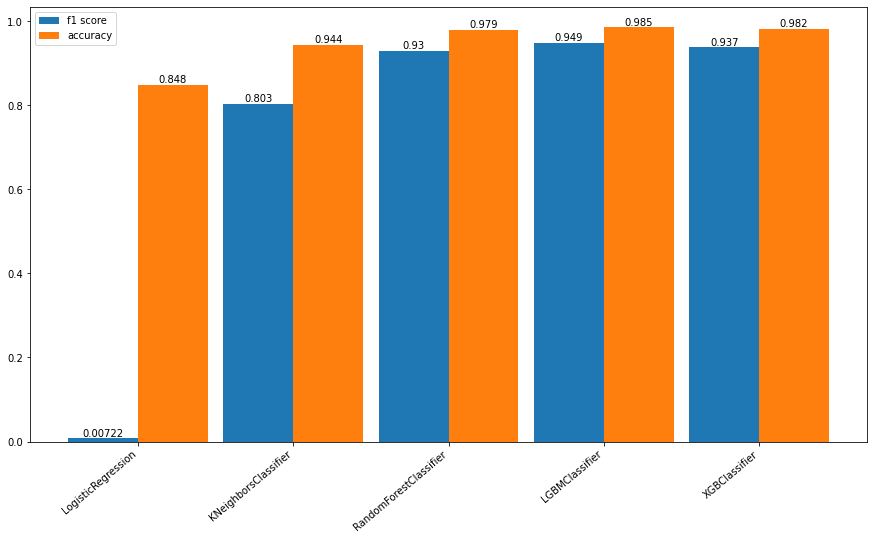

In [30]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)

classifiers = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    lgb.LGBMClassifier(random_state=42),
    xgb.XGBClassifier(random_state=42)
]

preprocessing_pipeline = Pipeline([
    # ('impoter', SimpleImputer(strategy='mean')),
    ('nomalize', MinMaxScaler())
    # ('standard', StandardScaler())
])

x, y, x_train, y_train, x_test, y_test = data_preporcess(df_without_missing_row[num_feature_list+['FLAG']], test_size=0.2, random_state=1234, shuffle=True)
model_select(x_train, y_train, classifiers, cv)

### df_without_missing_row & num_feature & smote

Total shape:  (8963, 39) (8963,)
Train shape:  (7170, 39) (7170,)
Test shape:  (1793, 39) (1793,)
Shape of the training before SMOTE: ((7170, 39), (7170,))
Shape of the training after SMOTE: ((12162, 39), (12162,))
BEFORE OVERSAMPLING 
 	Non-frauds: 6081 
 	Fauds: 1089
AFTER OVERSAMPLING 
 	Non-frauds: 6081 
 	Fauds: 6082
1-of-5: LogisticRegression f1=0.7308361777078767, acc=0.686811988935038


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


2-of-5: KNeighborsClassifier f1=0.9444040862379227, acc=0.9432664487204449
3-of-5: RandomForestClassifier f1=0.9884067002691946, acc=0.9884061600904234
4-of-5: LGBMClassifier f1=0.9898267821823057, acc=0.9898041864062128
5-of-5: XGBClassifier f1=0.9808887261089818, acc=0.9808418240422265


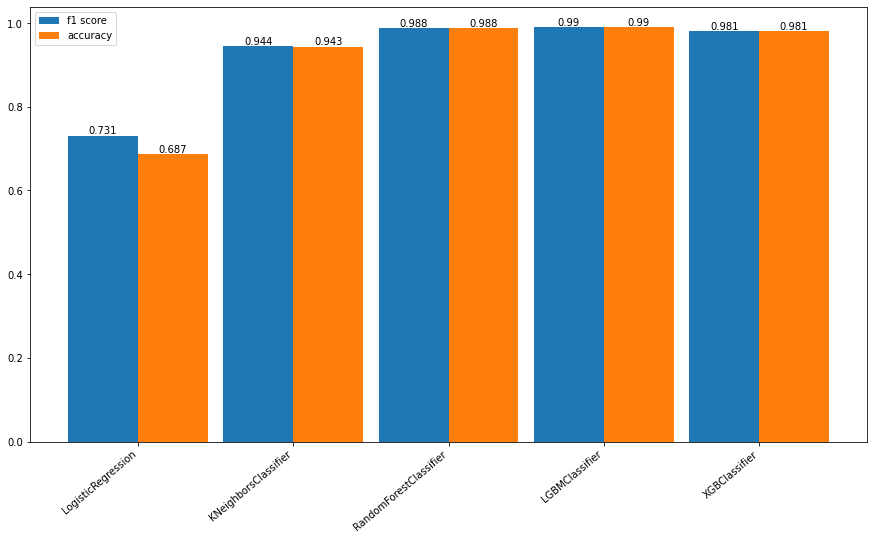

In [31]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)

classifiers = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    lgb.LGBMClassifier(random_state=42),
    xgb.XGBClassifier(random_state=42)
]

preprocessing_pipeline = Pipeline([
    # ('impoter', SimpleImputer(strategy='mean')),
    ('nomalize', MinMaxScaler())
    # ('standard', StandardScaler())
])

x, y, x_train, y_train, x_test, y_test = data_preporcess(df_without_missing_row[num_feature_list+['FLAG']], test_size=0.2, random_state=1234, shuffle=True)
x_train_balance, y_train_balance = smote_balance(x_train, y_train)
model_select(x_train_balance, y_train_balance, classifiers, cv)

### num feature with mean import

Total shape:  (9823, 39) (9823,)
Train shape:  (7858, 39) (7858,)
Test shape:  (1965, 39) (1965,)
1-of-5: LogisticRegression f1=0.01684484584473779, acc=0.7775517773642175
2-of-5: KNeighborsClassifier f1=0.8718417120839105, acc=0.9450242386253386
3-of-5: RandomForestClassifier f1=0.9561156118653699, acc=0.9809110095027073
4-of-5: LGBMClassifier f1=0.9686257752805953, acc=0.9861283472869422
5-of-5: XGBClassifier f1=0.9580841189862129, acc=0.9815469798494663


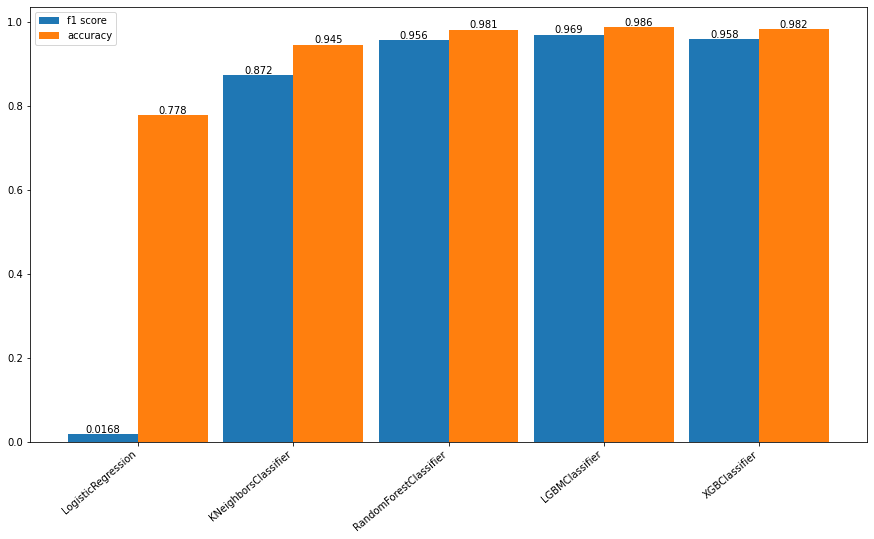

In [82]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)

classifiers = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    lgb.LGBMClassifier(random_state=42),
    xgb.XGBClassifier(random_state=42)
]

preprocessing_pipeline = Pipeline([
    ('impoter', SimpleImputer(strategy='mean')),
    ('nomalize', MinMaxScaler())
    # ('standard', StandardScaler())
])

x, y, x_train, y_train, x_test, y_test = data_preporcess(df[num_feature_list+['FLAG']], test_size=0.2, random_state=1234, shuffle=True)
model_select(x_train, y_train, classifiers, cv)

#### Best model selection on RandomForest

In [83]:
def best_model_select_RF(x_train, y_train, x_test, y_test):
    RFC_parameters = {
            'randomforestclassifier__n_estimators': range(50, 1050, 100),
            'randomforestclassifier__max_depth': range(50, 300, 20),
            'randomforestclassifier__min_samples_split': [2, 5, 10],
            'randomforestclassifier__min_samples_leaf': [1, 2, 4],
            'randomforestclassifier__bootstrap': [True, False]
    }

    RFC_pipeline = make_pipeline(preprocessing_pipeline, RandomForestClassifier(random_state=42))
    RFC_grid_search = RandomizedSearchCV(
        RFC_pipeline,
        param_distributions=RFC_parameters,
        scoring = 'f1',
        n_iter = 24,
        n_jobs = -1,
        cv = 5,
        random_state=42
    )

    RFC_grid_search.fit(x_train, y_train)

    display(RFC_grid_search.best_score_)
    display(RFC_grid_search.best_params_)
    dict1 = RFC_grid_search.best_params_
    new_key = ['n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_depth', 'bootstrap']
    model_dict = dict(zip(new_key, list(dict1.values())))

    X_train = preprocessing_pipeline.fit_transform(x_train)
    X_test = preprocessing_pipeline.transform(x_test)

    best_model_RF = RandomForestClassifier(**model_dict)
    
    best_model_RF.fit(X_train, y_train)
    predictions = best_model_RF.predict(X_test)
    print("f1 score = {}".format(f1_score(y_test, predictions)))

    print("ROC AUC score = {}".format(roc_auc_score(y_test, predictions)))

    print("accuracy score = {}".format(accuracy_score(y_test, predictions)))

    display(plot_confusion_matrix(best_model_RF, X_test, y_test))
    
    return best_model_RF

0.959140316334023

{'randomforestclassifier__n_estimators': 350,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_depth': 230,
 'randomforestclassifier__bootstrap': False}

f1 score = 0.9551515151515151
ROC AUC score = 0.9639082479198213
accuracy score = 0.9811704834605598


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


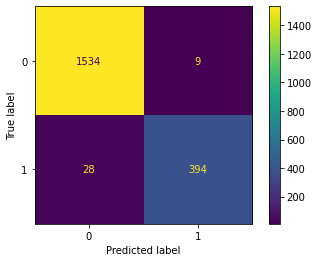

In [84]:
best_model_RF = best_model_select_RF(x_train, y_train, x_test, y_test)

#### Feature importance

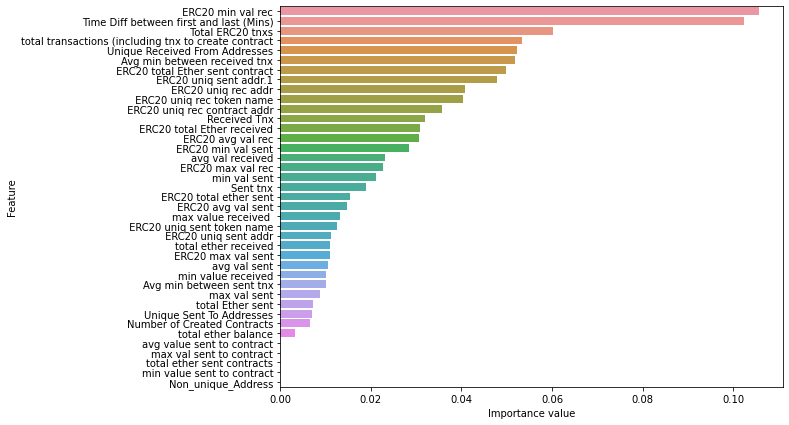

In [85]:
df_feature_importance = plot_features_importance(df[num_feature_list+['FLAG']], best_model_RF.feature_importances_)

#### feature selection

In [88]:
top_feature = df_feature_importance.Feature[:10].to_list()

Total shape:  (9823, 10) (9823,)
Train shape:  (7858, 10) (7858,)
Test shape:  (1965, 10) (1965,)


0.9559295171908125

{'randomforestclassifier__n_estimators': 150,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_depth': 270,
 'randomforestclassifier__bootstrap': True}

f1 score = 0.951338199513382
ROC AUC score = 0.9603537455501531
accuracy score = 0.9796437659033079


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


f1 score = 0.9490291262135923
ROC AUC score = 0.959705657410166
accuracy score = 0.9786259541984733


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


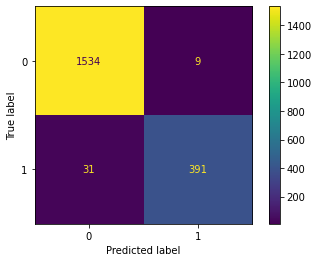

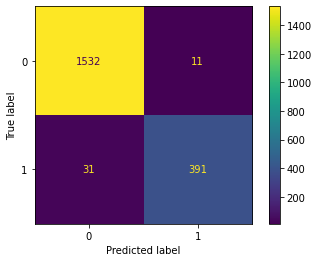

In [89]:
fit_after_select(df, top_feature)